<a href="https://colab.research.google.com/github/Norod/my-colab-experiments/blob/master/Simple_ruDALLE_inference_%5Bsupports_v1_0_0%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Information
import multiprocessing
import torch
from psutil import virtual_memory

ram_gb = round(virtual_memory().total / 1024**3, 1)

print('CPU:', multiprocessing.cpu_count())
print('RAM GB:', ram_gb)
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device.type)

!nvidia-smi

CPU: 2
RAM GB: 12.7
PyTorch version: 1.10.0+cu111
CUDA version: 11.1
cuDNN version: 8005
device: cuda
Sat Jan 15 18:39:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    44W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------

In [2]:
!pip install --upgrade rudalle ruclip translators > /dev/null

In [3]:
#@title Imports
import translators
import ruclip
from rudalle.pipelines import generate_images, show, super_resolution, cherry_pick_by_ruclip
from rudalle import get_rudalle_model, get_tokenizer, get_vae, get_realesrgan
from rudalle.utils import seed_everything

Using United States server backend.


In [4]:
device = 'cuda'
model_id = "Malevich" #@param ["Malevich", "Emojich"]
dalle = get_rudalle_model(model_id, pretrained=True, fp16=True, device=device)
tokenizer = get_tokenizer()
vae = get_vae(dwt=True).to(device)

◼️ Malevich is 1.3 billion params model from the family GPT3-like, that uses Russian language and text+image multi-modality.
tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
vae --> ready


In [5]:
# pipeline utils:
realesrgan = get_realesrgan('x2', device=device)
clip, processor = ruclip.load('ruclip-vit-base-patch32-384', device=device)
clip_predictor = ruclip.Predictor(clip, processor, device, bs=8)

x2 --> ready


## generation by ruDALLE

In [6]:
def simple_detect_lang(text):
    if len(set('абвгдежзийклмнопрстуфхцчшщъыьэюяё').intersection(text.lower())) > 0:
        return 'ru'
    if len(set('abcdefghijklmnopqrstuvwxyz').intersection(text.lower())) > 0:
        return 'en'
    return 'other'

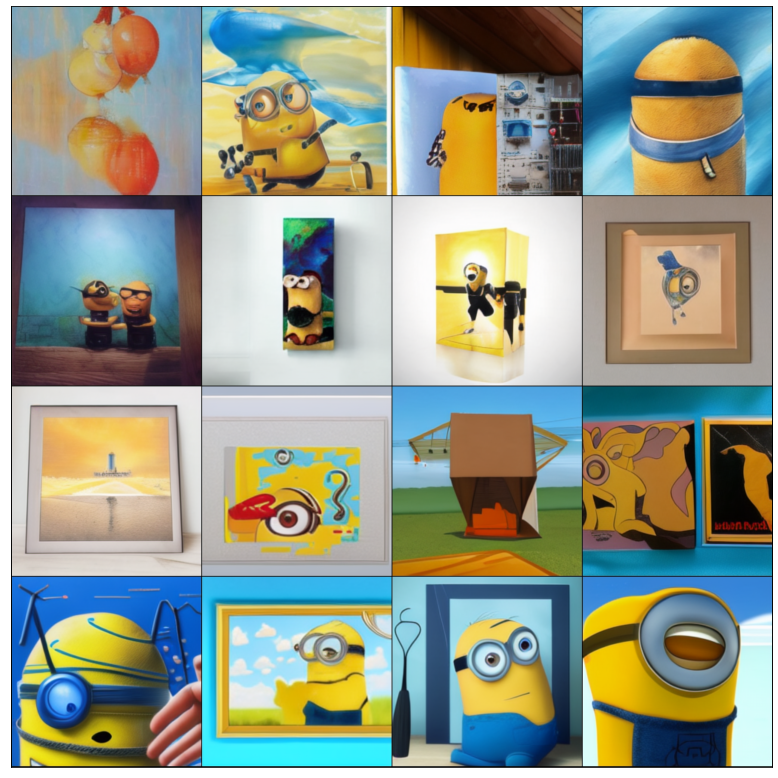

In [7]:
from IPython.display import clear_output

# Auto translation to Russian (or you can type Russian text directly)
text = 'Minions, oil on canvas' #@param {type:"string"}

if simple_detect_lang(text) != 'ru':
    text = translators.google(text, from_language='auto', to_language='ru')
print('text:', text)

seed = 42 #@param {type:"number"}
seed_everything(seed)

number_of_images = "16" #@param {type:"number"},[24, 16, 8]
number_of_images = int(number_of_images)
batch_size = int(number_of_images / 8)

pil_images = []
scores = []
for top_k, top_p, images_num in [
    (2048, 0.995, batch_size),
    (1536, 0.99, batch_size),
    (1024, 0.99, batch_size),
    (1024, 0.98, batch_size),
    (512, 0.97, batch_size),
    (384, 0.96, batch_size),
    (256, 0.95, batch_size),
    (128, 0.95, batch_size)
]:
    _pil_images, _scores = generate_images(text, tokenizer, dalle, vae, top_k=top_k, images_num=images_num, bs=8, top_p=top_p)
    pil_images += _pil_images
    scores += _scores
    clear_output()
    show([pil_image for pil_image, score in sorted(zip(pil_images, scores), key=lambda x: -x[1])] , 4)

## auto-cherry-pick by ruCLIP + super resolution

16it [00:00, 64.41it/s]


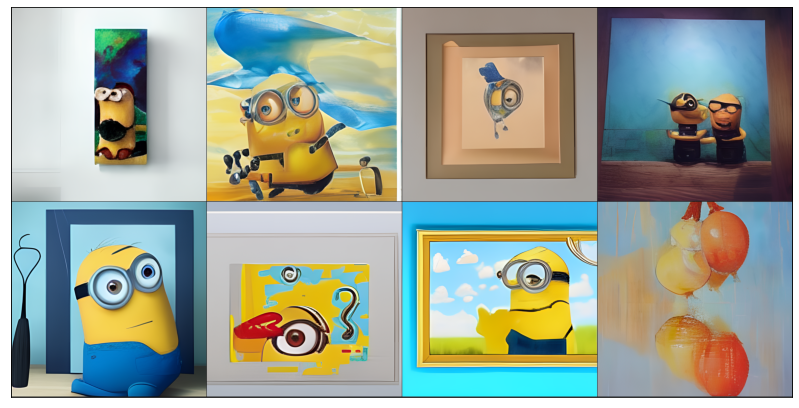

In [8]:
top_images, clip_scores = cherry_pick_by_ruclip(pil_images, text, clip_predictor, count=int(number_of_images/2))
sr_images = super_resolution(top_images, realesrgan)
show(sr_images, 4)